### This code is used to test how does kpca perform on non-linear clustering using generated samples instead of on x-ray images

In [2]:
from sklearn.datasets import make_circles
import matplotlib.pyplot as plt

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import warnings


In [11]:
# build the kernel, total 3 functions
import numpy as np

class kernel:
    
    def __init__(self, gamma = 1, sigma = 1, d_anova = 1, d_poly = 2, d_power = 1, alpha = 1, c = 0):
        self.gamma = gamma
        self.sigma = sigma
        self.d_anova = d_anova
        self.alpha = alpha
        self.c = c
        self.d_poly = d_poly
        self.d_power = d_power
        
    
    
    def rbf(self, x, y):
        """
        k(x, y) = exp(- gamma * ||x-y||^2)
        Hiperparametros: gamma
        """
        return np.exp(- self.gamma * (np.linalg.norm(x-y)**2))
    
    
    def polynomial(self, x, y):
        """
        k(x, y) = (alpha * <x, y> + c)^d
        Hiperparametros: alpha, c, d_poly
        """
        return (self.alpha * (x.T@y) + self.c)**self.d_poly
    
    def sigmoid(self, x, y):
        """
        k(x, y) = tanh( alpha * <x, y> + c)
        Hiperparametros: alpha, c
        """
        return np.tanh(self.alpha * (x.T@y) + self.c)
    
    

In [12]:
#build the kpca
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import warnings

class KPCA:
    def __init__(self, X, kernel, d):
        """
        KPCA object
        Parameters
        ----------
        
        X: dxn matrix
        kernel: kernel function from kernel class
        d: number of principal components to be chosen
        """
        self.X = X
        self.kernel = kernel 
        self.d = d
    
    def _is_pos_semidef(self, x):
        return np.all(x >= 0)

    def __kernel_matrix(self):
        """
        Compute kernel matrix
        Output:
        
        K: nxn matrix
        """
        K = []
        r, c = self.X.shape
        for fil in range(c):
            k_aux = []
            for col in range(c):
                k_aux.append(self.kernel(self.X[:, fil], self.X[:, col]))
            K.append(k_aux)
        K = np.array(K)
        # Centering K
        ones = np.ones(K.shape)/c
        K = K - ones@K - K@ones + ones@K@ones
        return K
    
    def __descomp(self):
        """
        Decomposition of K
        Output:
        
        tuplas_eig: List of ordered tuples by singular 
                    values; (singular_value, eigenvector)
        """
        self.K = self.__kernel_matrix()
        eigval, eigvec = np.linalg.eig(self.K)
        if not self._is_pos_semidef(eigval):
            warnings.warn("La matriz K no es semidefinida positiva")
        # Normalize eigenvectors and compute singular values of K
        tuplas_eig = [(np.sqrt(eigval[i]), eigvec[:,i]/np.sqrt(eigval[i]) ) for i in range(len(eigval))]
        tuplas_eig.sort(key=lambda x: x[0], reverse=True)
        return tuplas_eig
    
    def project(self):
        """
        Compute scores
        Output:
        
        scores: T = sigma * V_d^t
        """
        self.tuplas_eig = self.__descomp()
        tuplas_eig_dim = self.tuplas_eig[:self.d]
        self.sigma = np.diag([i[0] for i in tuplas_eig_dim])
        self.v = np.array([list(j[1]) for j in tuplas_eig_dim]).T
        self.sigma = np.real_if_close(self.sigma, tol=1)
        self.v = np.real_if_close(self.v, tol=1)
        self.scores = self.sigma @ self.v.T
        return self.scores
    
    def plot_singular_values(self, grid = True):
        eig_plot = [np.real_if_close(e, tol=1) for (e, _) in self.tuplas_eig if e > 0.01]
        plt.style.use('seaborn-whitegrid')
        fig = plt.figure(figsize=(15,7.5))
        plt.plot(list(range(1, len(eig_plot) + 1)), eig_plot)
        plt.grid(grid)
        plt.title('Valores singulares de la matriz $K$ distintos de 0')
        plt.ylabel('$\sigma^2$')
        plt.show()
        
    def plot_scores_2d(self, colors, grid = True, dim_1 = 1, dim_2 = 2):
        if self.d < 2:
            warnings.warn("No hay suficientes componentes prinicpales")
            return
        
        plt.style.use('seaborn-whitegrid')
        fig = plt.figure(figsize=(15,10))
        plt.axhline(c = 'black', alpha = 0.2)
        plt.axvline(c = 'black', alpha = 0.2)
        plt.scatter(self.scores[dim_1 - 1,:], self.scores[dim_2 - 1,:], c = colors)
        plt.grid(grid)
        plt.title('KPCA Space')
        plt.xlabel('${}^a$ componente principal en el espacio $\phi(X)$'.format(dim_1))
        plt.ylabel('${}^a$ componente principal en el espacio $\phi(X)$'.format(dim_2))
        plt.show()
        
    def plot_scores_3d(self, colors, grid = True, dim_1 = 1, dim_2 = 2, dim_3 = 3):
        if self.d < 3:
            warnings.warn("No hay suficientes componentes prinicpales")
            return
        
        plt.style.use('seaborn-whitegrid')
        fig = plt.figure(figsize=(15,10))
        ax = fig.add_subplot(111, projection="3d")
        ax.scatter(self.scores[dim_1 - 1,:], self.scores[dim_2 - 1,:], self.scores[dim_3 - 1,:], c = colors)
        plt.grid(grid)
        ax.axis('on')
        plt.title('KPCA Space')
        ax.set_xlabel('${}^a$ componente principal en el espacio $\phi(X)$'.format(dim_1))
        ax.set_ylabel('${}^a$ componente principal en el espacio $\phi(X)$'.format(dim_2))
        ax.set_zlabel('${}^a$ componente principal en el espacio $\phi(X)$'.format(dim_3))
        plt.show()
        
    def plot_density(self, labels, dim=1, grid = False):
        plt.style.use('seaborn-whitegrid')
        fig = plt.figure(figsize=(15,5))
        for ele in np.unique(labels):
            sns.distplot(self.scores[dim - 1,:][np.where(labels == ele)], hist = False, 
                         kde = True, kde_kws = {'linewidth': 3}, label = ele)
        plt.grid(grid)
        plt.legend()
        plt.title('Distribuciones en la ${}^a$ componente principal'.format(dim))
        plt.show()

In [13]:
# create a sample code
X, Y = make_circles(n_samples=200, noise =0.1, factor= 0.0002)
colors = ['#FFB300' if e==1 else '#E64A19' for e in Y]

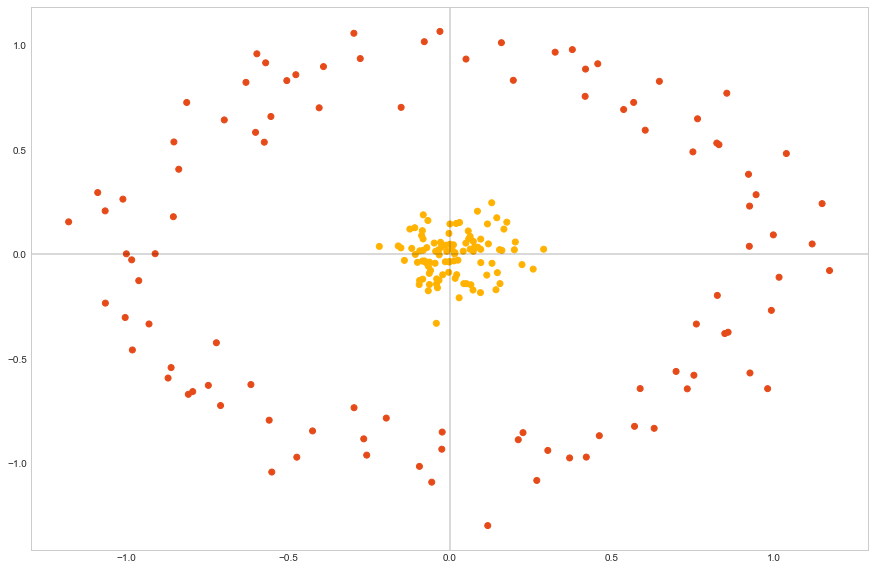

In [14]:
plt.style.use('seaborn-whitegrid')
fig = plt.figure(figsize=(15,10))
plt.axhline(c = 'black', alpha = 0.2)
plt.axvline(c = 'black', alpha = 0.2)
plt.scatter(X[:,0], X[:,1], c = colors)
plt.grid(False)
plt.show()

In [109]:
# apply KPCA
X = X.T # X must be dxn

#uncomment this for gaussian kernel
#k = kernel(gamma = 25).rbf 

#uncomment this for polynomial kernal
#k = kernel(alpha=4,c=1,d_poly=2).polynomial

#uncomment this for sigmoid kernel
k = kernel(alpha=0.2,c=1).sigmoid
kpca = KPCA(X, k, 3)
scores = kpca.project()

<ipython-input-12-af2d44b37e5b>:56: UserWarning: La matriz K no es semidefinida positiva
  warnings.warn("La matriz K no es semidefinida positiva")


In [110]:
T = kpca.scores #Matrix of scores
K = kpca.K #Kernel matrix
V = kpca.v #Matrix of eigenvectors
S = kpca.sigma #Diagonal matrix of (real) singular values

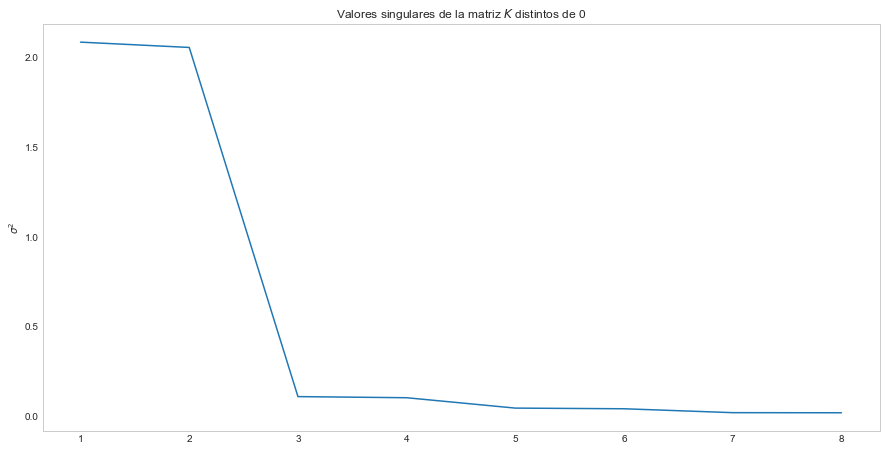

In [111]:
kpca.plot_singular_values(grid = False)

/Users/yyj/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/yyj/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


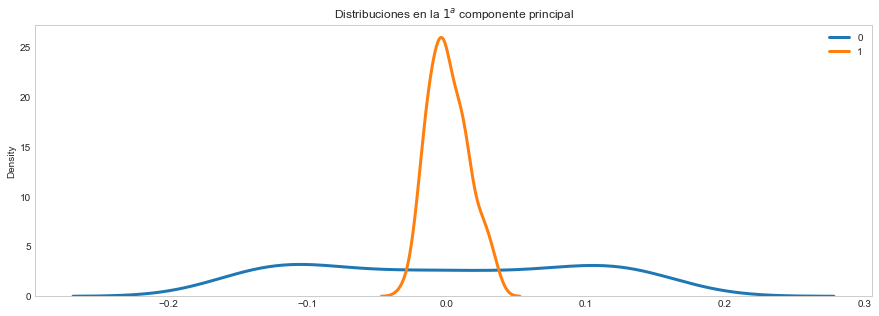

In [112]:
kpca.plot_density(labels = Y, dim=1, grid = False)

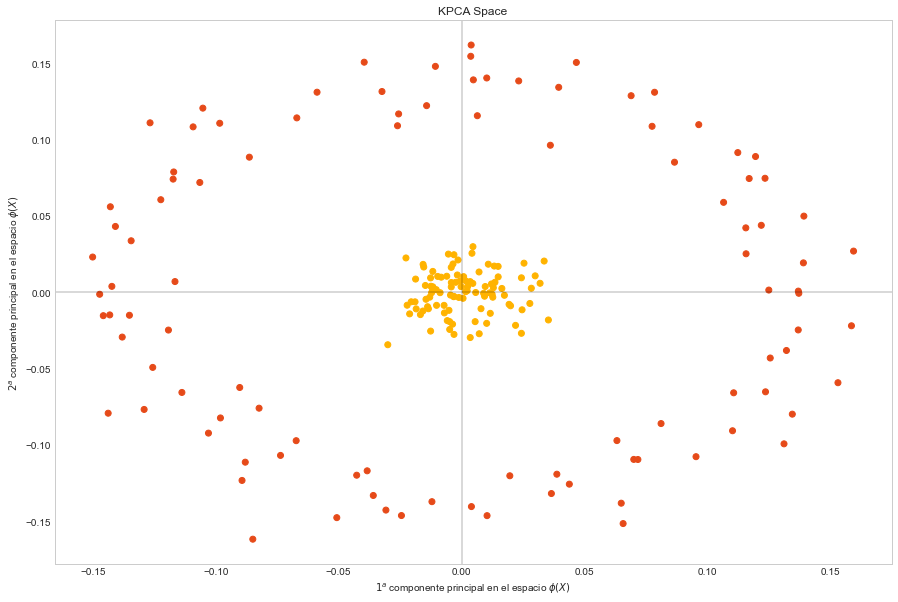

In [113]:
kpca.plot_scores_2d(colors = colors, grid = False, dim_1 = 1, dim_2 = 2)

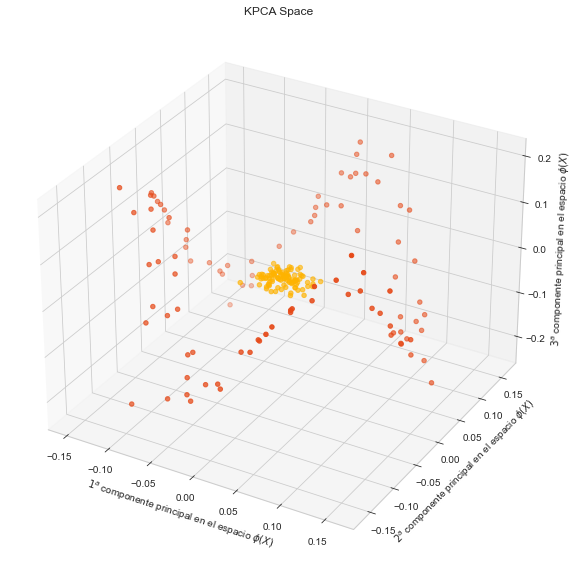

In [114]:
kpca.plot_scores_3d(colors = colors, dim_1 = 1, dim_2 = 2, dim_3 = 3)